In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import fused_kalman_localization as fkl

import matplotlib as mpl
mpl.style.use('seaborn-v0_8')

In [3]:
data = []
df_row = {}
LAST_CORNER = 2377

with open('linpots.json', 'r') as f:
    for line in tqdm(f.readlines()):
        row = eval(line.strip())

        if df_row == {}:
          df_row['ts'] = row['ts']

        corner = row['id']
        df_row[corner] = row['meter']

        if corner == LAST_CORNER:
          data.append(df_row)
          df_row = {}

df = pd.DataFrame(data)
df.columns = ['ts', 'FL', 'FR', 'RL', 'RR']
df['ts'] -= df['ts'].min()
# df['ts'] = pd.to_datetime(df['ts'])
df

100%|██████████| 537514/537514 [00:03<00:00, 151928.83it/s]


,ts,FL,FR,RL,RR
0,0.000000,0.495614,0.491917,0.428815,0.458122
1,0.188712,0.495614,0.491917,0.428815,0.458122
2,0.283078,0.495614,0.491917,0.428815,0.458122
3,0.372358,0.495614,0.491917,0.428815,0.458122
4,0.445120,0.495614,0.491917,0.428947,0.458254
...,...,...,...,...,...
134370,11831.305817,0.463403,0.474624,0.453370,0.457198
134371,11831.368938,0.463403,0.474492,0.453370,0.457198
134372,11831.429513,0.463403,0.474624,0.453370,0.457198
134373,11831.490478,0.463403,0.474624,0.453370,0.457198


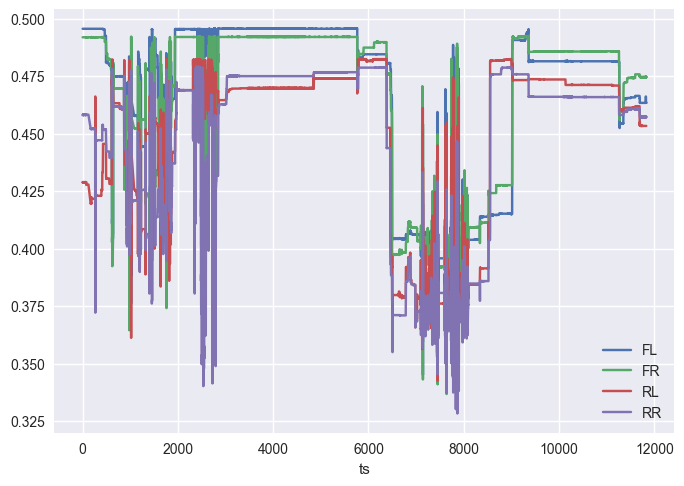

In [4]:
df.plot(x='ts')
plt.show()

In [5]:
df['ts'].max() / 60 / 60 # Hours?

np.float64(3.2865451182921728)

In [6]:
df['ts_delta'] = df['ts'].diff()

df['FL_vel'] = df['FL'].diff() / df['ts_delta']
df['FR_vel'] = df['FR'].diff() / df['ts_delta']
df['RL_vel'] = df['RL'].diff() / df['ts_delta']
df['RR_vel'] = df['RR'].diff() / df['ts_delta']

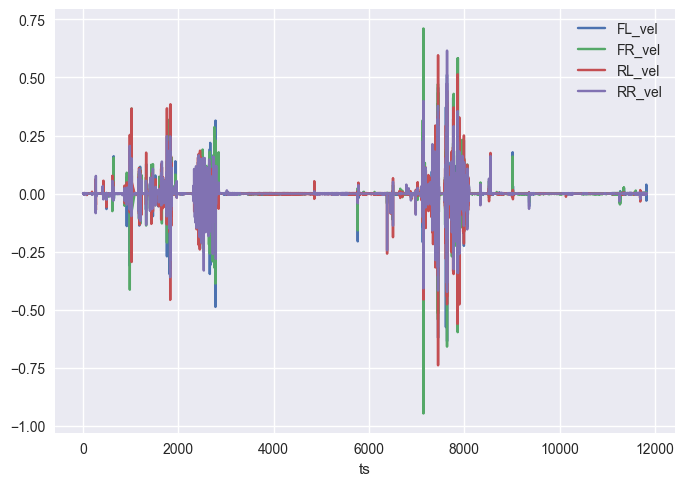

In [7]:
df.plot(x='ts', y=['FL_vel', 'FR_vel', 'RL_vel', 'RR_vel'])
plt.show()

In [8]:
df.describe()

,ts,FL,FR,RL,RR,ts_delta,FL_vel,FR_vel,RL_vel,RR_vel
count,134375.000000,134375.000000,134375.000000,134375.000000,134375.000000,134374.000000,134374.000000,134374.000000,134374.000000,134374.000000
mean,6275.690687,0.465461,0.464149,0.449459,0.447118,0.088049,-0.000002,0.000008,-0.000005,0.000009
std,3247.202687,0.036232,0.036855,0.036093,0.039007,0.742277,0.012450,0.014094,0.013788,0.011142
min,0.000000,0.345119,0.336802,0.340102,0.328353,0.049643,-0.640219,-0.946633,-0.739229,-0.423375
25%,3775.584542,0.440036,0.427627,0.428155,0.425515,0.071400,0.000000,0.000000,0.000000,0.000000
50%,6302.271784,0.481488,0.485713,0.469739,0.465911,0.077328,0.000000,0.000000,0.000000,0.000000
75%,8921.799484,0.495614,0.492050,0.473568,0.475020,0.085026,0.000000,0.000000,0.000000,0.000000
max,11831.562426,0.495746,0.492446,0.482413,0.479244,180.459355,0.511912,0.710920,0.595840,0.615603


In [9]:
df.to_csv('linpots.csv', index=False) 

In [10]:
df['pythag_vel'] = np.sqrt(df['FL_vel']**2 + df['FR_vel']**2 + df['RL_vel']**2 + df['RR_vel']**2)

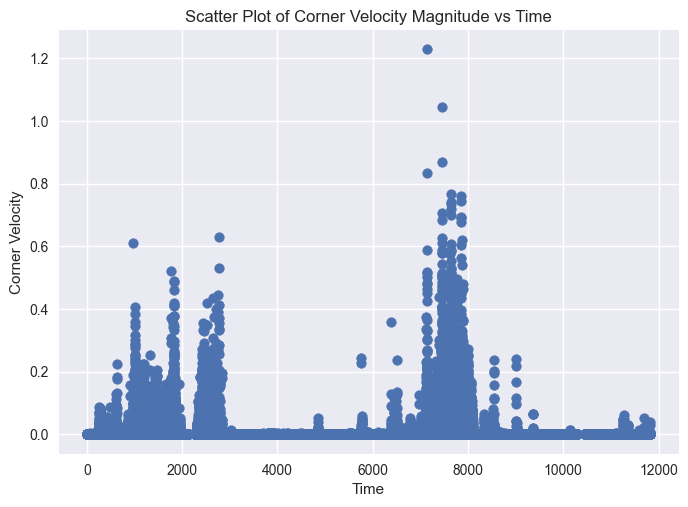

In [11]:
movement_regions = df['pythag_vel'] != 0.0
plt.scatter(df.loc[movement_regions, 'ts'],\
  df.loc[movement_regions, 'pythag_vel'])
plt.xlabel('Time')
plt.ylabel('Corner Velocity')
plt.title('Scatter Plot of Corner Velocity Magnitude vs Time')
plt.show()

array([[<Axes: title={'center': 'pythag_vel'}>]], dtype=object)

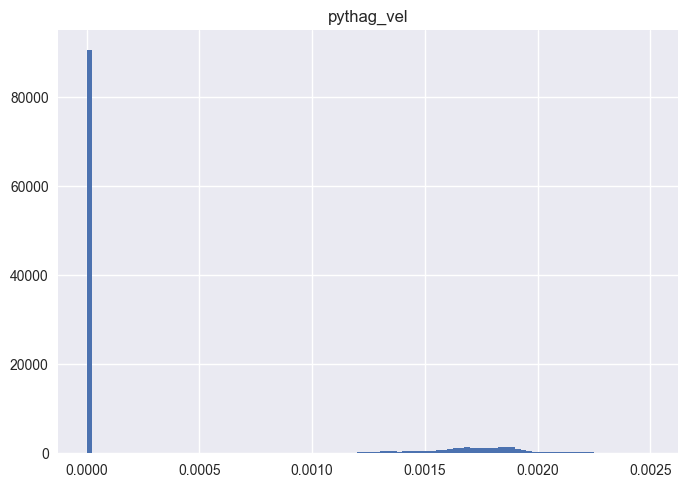

In [12]:
small = df[df['pythag_vel'] < 0.25e-2]
small.hist('pythag_vel', bins=100)

[]

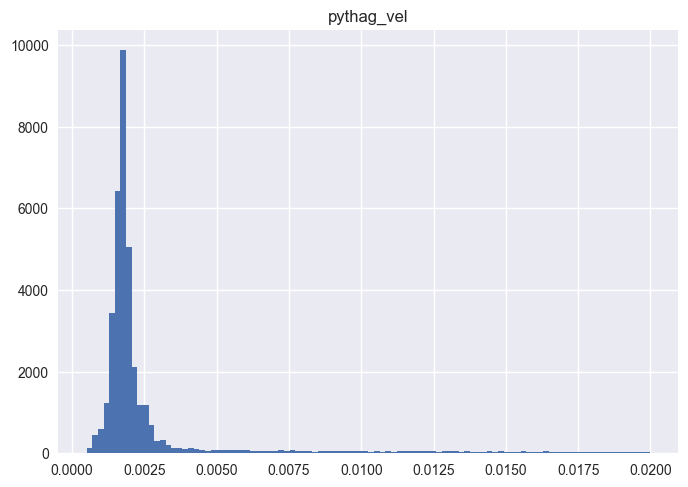

In [13]:
non_zero = df[(df['pythag_vel'] > 5e-4) & (df['pythag_vel'] < 0.02)]
non_zero.hist('pythag_vel', bins=100)
plt.plot()

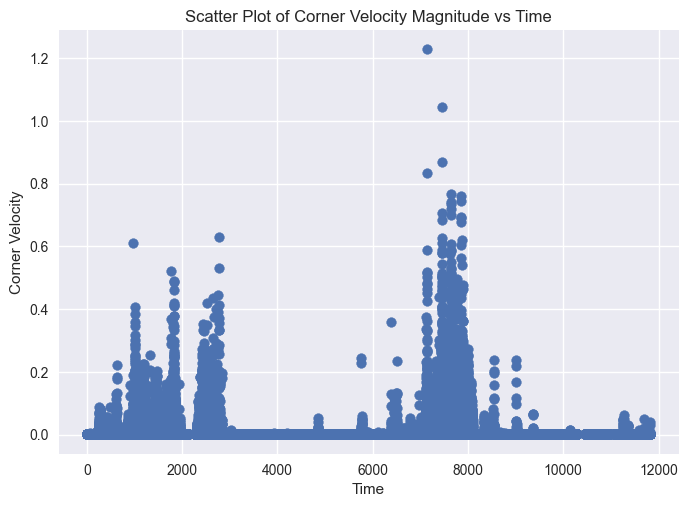

In [14]:
thresh = 5e-4

movement_regions = df['pythag_vel'] >= thresh
plt.scatter(df.loc[movement_regions, 'ts'],\
  df.loc[movement_regions, 'pythag_vel'])
plt.xlabel('Time')
plt.ylabel('Corner Velocity')
plt.title('Scatter Plot of Corner Velocity Magnitude vs Time')
plt.show()

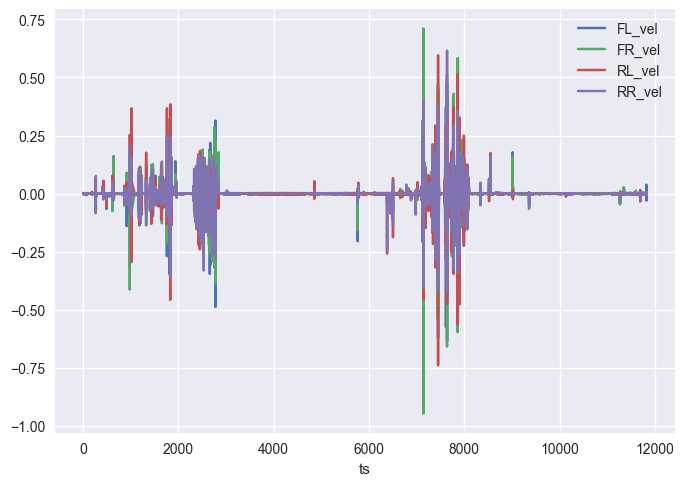

In [15]:
df[movement_regions].plot(x='ts', y=['FL_vel', 'FR_vel', 'RL_vel', 'RR_vel'])
plt.show()

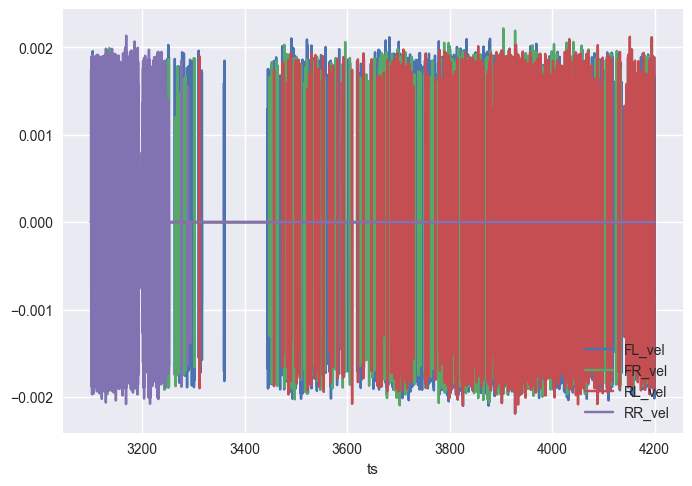

In [16]:
quiet = (df['ts'] > 3100) & (df['ts'] < 4200)
df[quiet].plot(x='ts', y=['FL_vel', 'FR_vel', 'RL_vel', 'RR_vel']) #, style=".")
# plt.legend()
plt.show()

,FL_vel,FR_vel,RL_vel,RR_vel
FL_vel,3.771324e-07,-2.937327e-09,6.949079e-09,-6.335360e-10
FR_vel,-2.937327e-09,2.049355e-07,6.061560e-09,1.438384e-09
RL_vel,6.949079e-09,6.061560e-09,1.888254e-07,6.587185e-11
RR_vel,-6.335360e-10,1.438384e-09,6.587185e-11,1.516727e-07


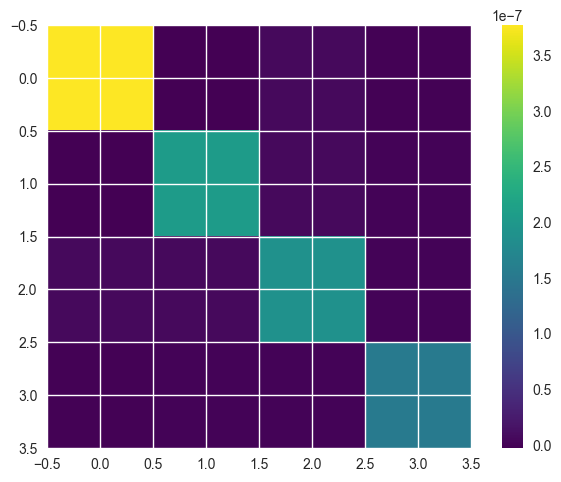

In [17]:
# Assuming df is your DataFrame and you have specific columns to consider
vel_cols = df.columns[-5:-1]  # Replace with actual column names

# Compute the covariance matrix
covariance_matrix = df.loc[quiet, vel_cols].cov()
display(covariance_matrix)

plt.imshow(covariance_matrix, cmap='viridis')
plt.colorbar()
plt.show()

,FL_vel,FR_vel,RL_vel,RR_vel
FL_vel,0.000155,0.000050,-0.000012,-0.000010
FR_vel,0.000050,0.000199,-0.000010,-0.000005
RL_vel,-0.000012,-0.000010,0.000190,0.000023
RR_vel,-0.000010,-0.000005,0.000023,0.000124


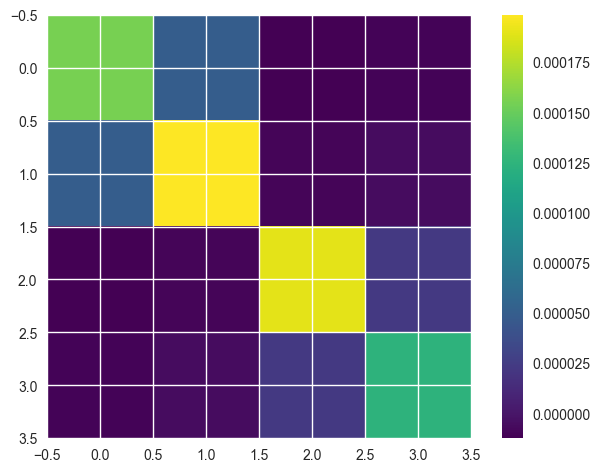

In [18]:
# Compute the covariance matrix
covariance_matrix = df.loc[:, vel_cols].cov()
display(covariance_matrix)

plt.imshow(covariance_matrix, cmap='viridis')
plt.colorbar()
plt.show()

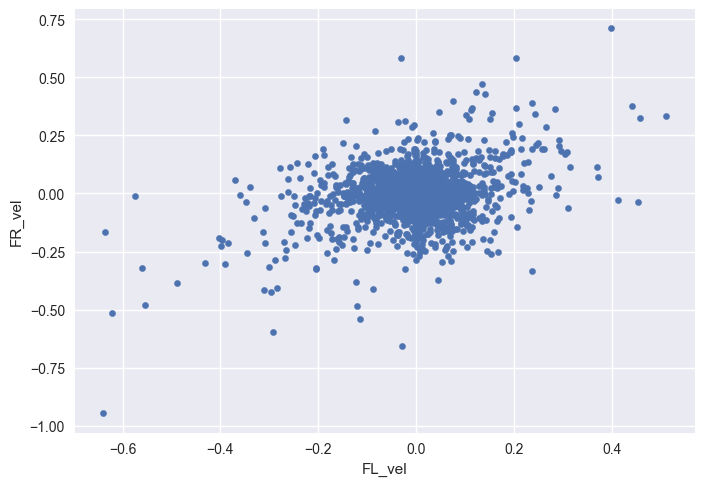

In [19]:
df.plot(x='FL_vel', y='FR_vel', kind='scatter')
plt.show()

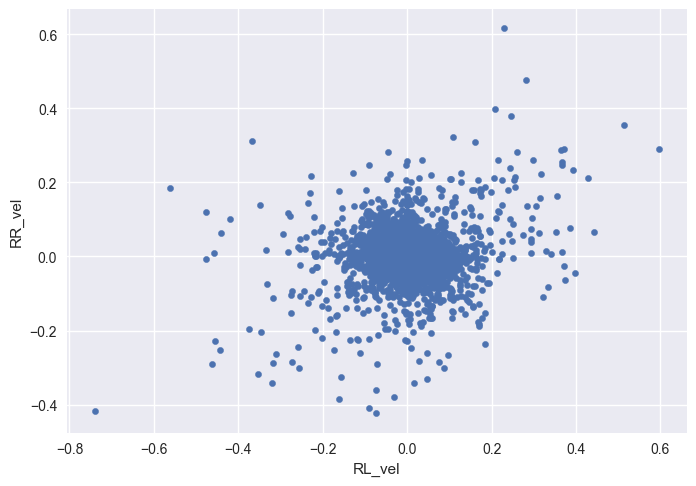

In [20]:
df.plot(x='RL_vel', y='RR_vel', kind='scatter')
plt.show()

## Position in quiet

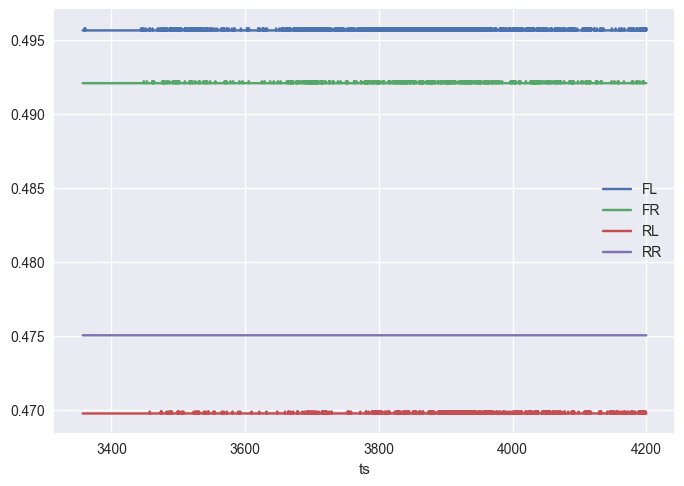

In [21]:
quiet = (df['ts'] > 3350) & (df['ts'] < 4200)
df[quiet].plot(x='ts', y=['FL', 'FR', 'RL', 'RR'])
# plt.legend()
plt.show()

In [22]:
df.columns

Index(['ts', 'FL', 'FR', 'RL', 'RR', 'ts_delta', 'FL_vel', 'FR_vel', 'RL_vel',
       'RR_vel', 'pythag_vel'],
      dtype='object')

,FL,FR,RL,RR
FL,1.348213e-09,6.484291e-11,8.382700e-11,0.0
FR,6.484291e-11,6.979877e-10,3.828487e-11,0.0
RL,8.382700e-11,3.828487e-11,6.805909e-10,0.0
RR,0.000000e+00,0.000000e+00,0.000000e+00,0.0


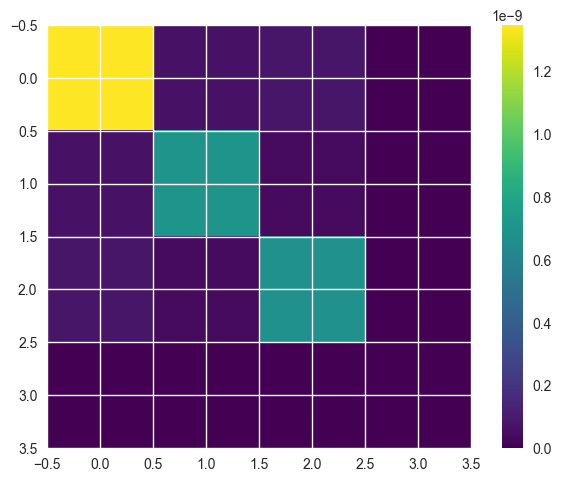

In [23]:
pos_cols = df.columns[1:5]  # Replace with actual column names

# Compute the covariance matrix
covariance_matrix = df.loc[quiet, pos_cols].cov()
display(covariance_matrix)

plt.imshow(covariance_matrix, cmap='viridis')
plt.colorbar()
plt.show()

,FL,FR,RL,RR
FL,0.001313,0.001234,0.001041,0.001100
FR,0.001234,0.001358,0.001065,0.001267
RL,0.001041,0.001065,0.001303,0.001299
RR,0.001100,0.001267,0.001299,0.001522


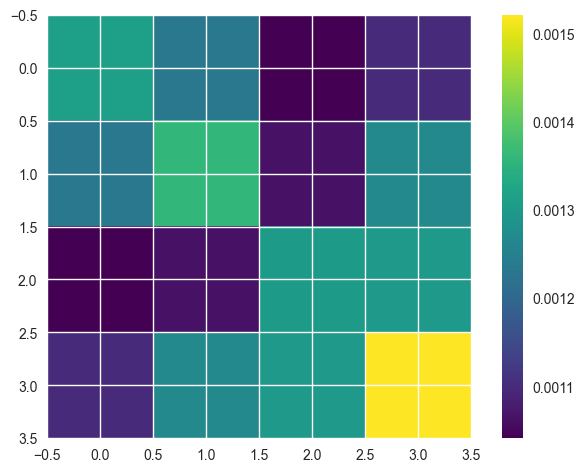

In [24]:
# Compute the covariance matrix
covariance_matrix = df.loc[:, pos_cols].cov()
display(covariance_matrix)

plt.imshow(covariance_matrix, cmap='viridis')
plt.colorbar()
plt.show()